# Replication Notebook

This notebook contains code and figure for the replication of the results in [Information Overload in Group Communication: From Conversation to Cacophony in the Twitch Chat](http://dx.doi.org/10.1098/rsos.191412) by Azadeh Nematzadeh, Giovanni Luca Ciampaglia, Yong-Yeol Ahn, and Alessandro Flammini.

Aggregated count data are provided to replicate results reported in Figure 2, 3, 4, 6, and 8. 

To be able to run this notebook you will need Python 3. Please follow the installation instructions provided in the README. These include instructions to obtain the data. 

This notebook was created by Giovanni Luca Ciampaglia <glciampagl@gmail.com>

## Imports

Run this cell before executing any other cell in this notebook. It will import all necessary modules.

In [98]:
%matplotlib inline

import os.path
import numpy
import pandas
import matplotlib
import contextlib
import matplotlib.pyplot as plt

from createdatasets import _bounds


def plot_channel_timeseries(df, channel, xlim=None, grouper=None, level=None, by=None, freq='5Min'):
    if level is not None or by is not None:
        grouper = df.groupby(level=level, by=by)
    elif grouper is None:
        raise ValueError("must pass one of grouper=, level=, or by=")
    a = grouper.get_group(channel).loc[channel]
    a = a.set_index('timestamp').sort_index()
    m = a.messages.mean()
    if xlim is not None:
        a = a.loc[slice(*xlim)]
    bounds = _bounds(a, df_mean=m)
    a = a.resample(freq, level='timestamp').sum().fillna(0)
    fig = plt.figure(figsize=(fig_width, fig_width / phi))
    ax = fig.add_subplot(111)
    plt.plot_date(a.index.values, a.messages.values.ravel(), 
                  color='black', linestyle='-', marker='')
    for item in bounds.itertuples(index=False):
        plt.axvspan(item.start, item.stop, color='lightgray', axes=ax) 
    ax.set_xlabel('')
    ax.set_ylabel('Messages', fontsize='medium')
    locator = matplotlib.dates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    formatter = matplotlib.dates.AutoDateFormatter(locator)
    ax.xaxis.set_major_formatter(formatter)
    plt.setp(ax.xaxis.get_ticklabels(), rotation=72, fontsize='small')
    ax.get_figure().tight_layout(pad=0.2)
    return ax


def plot(df, **kwargs):
    if len(df) == 0:
        return
    n_bins = 50
    emax = numpy.ceil(numpy.log10(df['messages'].max()))
    bins = numpy.logspace(0, emax, base=10, num=n_bins)
    digits = numpy.digitize(df['messages'], bins)
    dfg = df.groupby(digits, as_index=False).agg(['median', 'sem'])
    dfg.columns = ['_'.join(item) for item in dfg.columns.get_values()]
    ax = dfg.plot(x='messages_median',
                  y='messagespc_median',
                  yerr='messagespc_sem',
                  legend=False,
                  color='k',
                  linestyle='',
                  marker='o',
                  **kwargs)
    xmin, xmax = ax.get_xlim()
    ax.axvspan(xmin=40, xmax=xmax, color='gray', alpha=.2)
    ax.axvline(40, color='k')

## Data loading

Evaluate the following cell to load the data. By default, aggregated data files should have been downloaded in the sub-folder called `data`, relative to the path of the notebook itself. If you downloaded the data to a different location, change the value of the `data_path` variable below.

In [99]:
data_path = './data'

counts_fn = 'counts.h5'
counts_key = 'channel_5Min_total'
counts_path = os.path.join(data_path, counts_fn)
df_counts = pandas.read_hdf(counts_path, counts_key)

stats_fn = 'stats.h5'
stats_key = 'chan_stats'
stats_path = os.path.join(data_path, stats_fn)
df_stats = pandas.read_hdf(stats_path, stats_key)

## Figure 1

__caption__: _Study settings. (a) user interface of a Twitch stream. (b) schematic illustration of the information overload in a live streaming platform. Chat messages are information stimuli presented to the user at a certain rate (\`information load\'). A user participates in the conversation by writing messages into the chat at a certain rate (\`user activity\'). (c) Signature of information overload: user activity follows an inverted U-shape curve as a function of information load. This identifies two regimes, namely \`conversational\' and \`overloaded\' (shaded area). (d) two excerpts of chat logs: users chatting (left) and a situation with high repetition and disproportionate usage of emotes (right). In the overloaded regime messages will resemble more the latter than the former case._

<img src=./img/Figure_1.png width=600>


## Figure 2

__caption__: _A typical time series of the volume of chat messages in a stream. We sampled the number of messages posted in the stream every 5 minutes. Here peak activity corresponds to roughly 32.8 messages. We infer the periods when a live broadcast took place (shaded areas) from sudden shifts in activity (see Methods)._


__input__: `counts.h5`

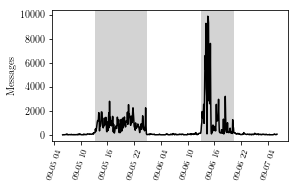

In [101]:
phi = 1.618  # figure aspect ratio
fig_width = 4  # in inches

# values used in the paper
channel = 3720
xlim = ('2014-09-05 06:00:00', '2014-09-07 06:00:00')
# xlim = None

df = df_counts.set_index('channel').loc[channel].copy()
ax = plot_channel_timeseries(df, channel, level=0, xlim=xlim)

## Figure 3

__caption__: _User activity (messages per capita $M$) as a function of information load (number of messages $V$). The gray shaded area indicates the regime of overload --- for a comparison, cf. Fig. 1(c). We include only streams with at least 1,000 messages and at least 100 user observed during the full observation window overall ($N = 43,969$). To compute $M$ we average across chunks of messages sampled every $\Delta t = 5\mbox{min}$. To mitigate fluctuations due to undetected bots, we use the median instead of the sample average, and consider only chunks with number of users $U > 1$. Error bars represent standard error of the mean._

__input__: `counts.h5` `stats.h5`

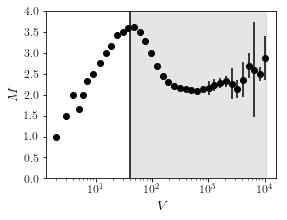

In [86]:
min_messages = 1000
min_users = 100
min_users_per_chunk = 1

ok_channels = df_stats.query('messages >= @min_messages & users >= @min_users').index.tolist()

query = \
    '(broadcast == True) & ' \
    '(messages > @min_users_per_chunk) & ' \
    'channel in @ok_channels'

df = df_counts.query(query)
plot(df, figsize=(4, 3))
ax = plt.gca()
plt.setp(ax.get_xaxis().get_ticklabels(), fontsize='large')
plt.setp(ax.get_yaxis().get_ticklabels(), fontsize='large')
plt.xlabel('$V$', fontsize='x-large')
plt.ylabel('$M$', fontsize='x-large')
plt.ylim(0, 4)
plt.xscale('log')

## Figure 4

__caption__: _User activity (messages per capita $M$) as a function of information load (number of messages $V$), broken down for the quartiles of the distribution of users per streams (see Fig. 8). The group with least active streams is denoted by $Q_1$. To estimate $M$, similar steps as in Fig. 3 were used, with the exception that we only consider chunks with $U > 2$._

__input__: `counts.h5`, `stats.h5`

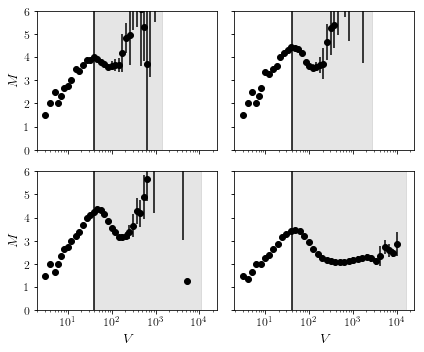

In [89]:
min_messages = 1000
min_users = 100
min_users_per_chunk = 2

df_stats_filt = df_stats.query('messages >= @min_messages & users >= @min_users').copy()

q = numpy.linspace(0, 100, 4, endpoint=False)
pc = numpy.percentile(df_stats_filt['messages'], q)
d = numpy.digitize(df_stats_filt['messages'], pc)
df_stats_filt['quartile'] = d

query = \
    '(broadcast == True) & ' \
    '(messages > @min_users_per_chunk) & ' \
    'channel in @ok_channels'

grouper = df_stats_filt.reset_index().groupby('quartile')['channel']
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 5), sharex=True, sharey=True)

for i, ax in zip(range(1, 5), axs.ravel()):
    ok_channels = grouper.get_group(i).tolist()
    df = df_counts.query(query)
    df = df.reset_index(drop=True)
    plot(df, ax=ax) 
    plt.sca(ax)
    plt.setp(ax.get_xaxis().get_ticklabels(), fontsize='large')
    plt.setp(ax.get_yaxis().get_ticklabels(), fontsize='large')
    plt.ylim(0, 6)
    plt.xscale('log')
    plt.xlabel('')
    plt.ylabel('')
    
axs[1, 0].set_xlabel('$V$', fontsize='x-large')
axs[1, 1].set_xlabel('$V$', fontsize='x-large')
axs[0, 0].set_ylabel('$M$', fontsize='x-large')
axs[1, 0].set_ylabel('$M$', fontsize='x-large')
plt.tight_layout()

## Figure 5

Not available.

## Figure 6

__caption__: _User activity (messages per capita $M$) as a function of information load (number of messages $V$) for periods of video inactivity (corresponding to unshaded areas in Fig. 3. During these periods the streamer is offline, and the video is either blank or set to a still image._

__input__: `counts.h5`

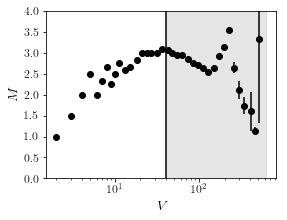

In [93]:
min_messages = 1000
min_users = 100
min_users_per_chunk = 1

ok_channels = df_stats.query('messages >= @min_messages & users >= @min_users').index.tolist()

query = \
    '(broadcast == False) & ' \
    '(messages > @min_users_per_chunk) & ' \
    'channel in @ok_channels'

df = df_counts.query(query)
plot(df, figsize=(4, 3))
ax = plt.gca()
plt.setp(ax.get_xaxis().get_ticklabels(), fontsize='large')
plt.setp(ax.get_yaxis().get_ticklabels(), fontsize='large')
plt.xlabel('$V$', fontsize='x-large')
plt.ylabel('$M$', fontsize='x-large')
plt.ylim(0, 4)
plt.xscale('log')

## Figure 7

Not available.

## Figure 8

__caption__: _Left:  distribution of the number of messages per stream (black dashed line) and per user (solid greyline).  Right:  distribution of the number of users per stream.  All quantities show broad distributions._

__input__: `stats.h5`


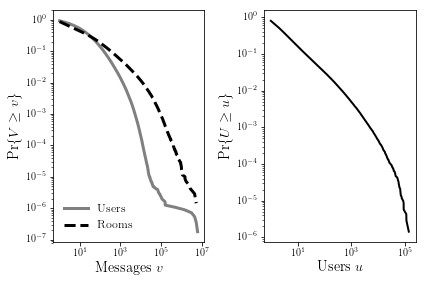

In [68]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))

# left panel - users
df = pandas.read_hdf(stats_path, 'user_stats')
df = df.drop_duplicates('messages').sort_values('messages')
ax = df.plot('messages', 'prob', ls='-', color='gray', lw=3, ax=axs[0], label='Users')

# left panel - channels
df = pandas.read_hdf(stats_path, 'chan_stats')
df = df.drop_duplicates('messages').sort_values('messages')
ax = df.plot('messages', 'messages_prob', ls='--', color='k', lw=3, ax=axs[0], label='Rooms')

# left panel
plt.sca(ax)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Messages $v$', fontsize='x-large')
plt.ylabel(r'$\Pr\{V \ge v\}$', fontsize='x-large')
plt.legend(loc='lower left', frameon=False, fontsize='large')

# right panel
df = pandas.read_hdf(stats_path, 'chan_stats')
df = df.drop_duplicates('users').sort_values('users')
ax = df.plot('users', 'users_prob', ls='-', color='k', lw=2, ax=axs[1], legend=False)
plt.sca(ax)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Users $u$', fontsize='x-large')
plt.ylabel(r'$\Pr\{U \ge u\}$', fontsize='x-large')

plt.tight_layout(pad=1.0)

## Figure 9

Not available.